In [1]:
import tensorflow as tf

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
import keras
from sklearn.model_selection import KFold


In [3]:
plt.rcParams.update(
    {
        "axes.grid": True,
        "grid.alpha": 0.5,
        "grid.linestyle": "--"
    }
)


## Import data

In [4]:
df = pd.read_csv("../data/FS_features_ABIDE_males.csv", sep=";")
df = df.set_index("FILE_ID")

# drop target
y = df["AGE_AT_SCAN"]
df = df.drop(["AGE_AT_SCAN", "SEX"], axis=1)

In [5]:
from sklearn.pipeline import Pipeline

# L1 regularization

linear_regressor = Pipeline(
    [
        ('scaler', PowerTransformer()),
        ("principal_components", PCA(n_components=20, svd_solver = 'full')),
        ("model",  Lasso())
    ]
)

param_distr = {"model__alpha": np.arange(1, 10)}


In [6]:
search = GridSearchCV(
    linear_regressor, 
    param_distr, 
    return_train_score=True, 
    scoring="r2", 
    cv=KFold(shuffle=True) # 5 split
)

search.fit(df.values, y.values)
print("Done")


Done


In [7]:
results_regressor = pd.DataFrame(search.cv_results_)
no_overfit = results_regressor["mean_train_score"] - results_regressor["mean_test_score"] < 6

(
    results_regressor[no_overfit]
    .sort_values("mean_test_score", ascending=False)
    .to_csv("best_model_regressor.csv", index=False)
)

In [8]:
results_regressor

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.082170,0.031829,0.018959,0.000963,1,{'model__alpha': 1},0.627481,0.663396,0.680098,0.636030,...,0.656434,0.021042,1,0.681996,0.671485,0.662360,0.670433,0.664104,0.670076,0.006919
1,1.063576,0.016696,0.019566,0.000557,2,{'model__alpha': 2},0.592633,0.629701,0.661870,0.599219,...,0.625730,0.026458,2,0.647118,0.636664,0.627052,0.641162,0.633921,0.637183,0.006754
2,1.048280,0.011892,0.018084,0.000540,3,{'model__alpha': 3},0.565414,0.615736,0.643024,0.570821,...,0.602155,0.029571,3,0.620352,0.614544,0.597967,0.615303,0.614108,0.612455,0.007582
3,1.049556,0.010791,0.018789,0.000344,4,{'model__alpha': 4},0.560284,0.599865,0.629426,0.562328,...,0.589740,0.025870,4,0.610516,0.592324,0.582471,0.604355,0.601269,0.598187,0.009807
4,1.048604,0.015534,0.018924,0.001187,5,{'model__alpha': 5},0.558501,0.591416,0.619986,0.555186,...,0.582313,0.023758,5,0.603441,0.584619,0.574655,0.596781,0.594389,0.590777,0.010073
5,1.049956,0.012525,0.019407,0.001010,6,{'model__alpha': 6},0.554380,0.581638,0.609292,0.546440,...,0.574712,0.022391,6,0.594793,0.575201,0.565101,0.587524,0.588586,0.582241,0.010668
6,1.044247,0.016093,0.018972,0.000541,7,{'model__alpha': 7},0.547921,0.570531,0.597345,0.536090,...,0.565581,0.021559,7,0.584573,0.564070,0.553811,0.576583,0.581728,0.572153,0.011553
7,1.064272,0.021544,0.019125,0.000738,8,{'model__alpha': 8},0.539124,0.558095,0.584145,0.524135,...,0.554918,0.021271,8,0.572781,0.551227,0.540784,0.563960,0.573814,0.560513,0.012765
8,1.097383,0.063088,0.019175,0.001426,9,{'model__alpha': 9},0.527989,0.544330,0.569691,0.510576,...,0.542725,0.021521,9,0.559417,0.536672,0.526020,0.549654,0.564845,0.547322,0.014325


In [9]:
pd.read_csv("best_model_regressor.csv").head(1).T

,0
mean_fit_time,1.08217
std_fit_time,0.031829
mean_score_time,0.018959
std_score_time,0.000963
param_model__alpha,1
params,{'model__alpha': 1}
split0_test_score,0.627481
split1_test_score,0.663396
split2_test_score,0.680098
split3_test_score,0.63603


## Neural network

In [10]:
from keras.layers import Dense, Dropout
from keras.models import Sequential
from scikeras.wrappers import KerasRegressor
from itertools import product
from sklearn.model_selection import RandomizedSearchCV


In [11]:
def twoLayerFeedForward(nlayers, hiddens, dropouts, meta):
    clf = Sequential()
    X_shape_ = (meta["X_shape_"][1],)

    clf.add(Dense(hiddens[0], activation='relu', input_shape=X_shape_))
    if dropouts[0] > 0:
        clf.add(Dropout(dropouts[0]))
    for i in range(1, nlayers):
        clf.add(Dense(hiddens[i], activation='relu'))
        if dropouts[i] > 0:
            clf.add(Dropout(dropouts[i]))
    clf.add(Dense(1))
    return clf


callback = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    restore_best_weights=True,
)


mlp = KerasRegressor(
    twoLayerFeedForward, 
    epochs=200, 
    loss="mse",
    callbacks=[callback],
    validation_split=0.2,
    nlayers=3,
    hiddens=[2,2,2],
    dropouts=[0.2, 0, 0],
    verbose=0
)

In [12]:
valid_entries = [4, 8, 16, 32, 64]
hidden_layers = list(product(valid_entries, repeat=6))
dropouts = list(np.random.choice([0.0, 0.1, 0.2, 0.3], p=[0.4, 0.2, 0.2, 0.2], size=(2000, 6)))
                     

In [13]:
model = Pipeline(
    [
        ('scaler', PowerTransformer()),
        ("principal_components", PCA(n_components=20, svd_solver = 'full')),
        ("mlp", mlp)
    ]
)

params = {
    "mlp__nlayers": np.random.randint(1, 7, size=22),
    "mlp__hiddens": hidden_layers,
    "mlp__dropouts": dropouts,
    "mlp__optimizer__learning_rate": [0.0001, 0.001, 0.005],
}

In [14]:
gs = RandomizedSearchCV(
    model, 
    params, 
    refit=False, 
    cv=KFold(shuffle=True), 
    return_train_score=True,
    scoring="neg_mean_absolute_error", 
    n_iter=100, 
    verbose=3
)

In [16]:
gs.fit(df, y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END mlp__dropouts=[0.3 0.2 0.  0.  0.  0.1], mlp__hiddens=(32, 32, 32, 4, 8, 32), mlp__nlayers=4, mlp__optimizer__learning_rate=0.0001;, score=(train=-3.895, test=-4.097) total time=  11.2s
[CV 2/5] END mlp__dropouts=[0.3 0.2 0.  0.  0.  0.1], mlp__hiddens=(32, 32, 32, 4, 8, 32), mlp__nlayers=4, mlp__optimizer__learning_rate=0.0001;, score=(train=-4.290, test=-5.258) total time=   8.8s
[CV 3/5] END mlp__dropouts=[0.3 0.2 0.  0.  0.  0.1], mlp__hiddens=(32, 32, 32, 4, 8, 32), mlp__nlayers=4, mlp__optimizer__learning_rate=0.0001;, score=(train=-4.647, test=-4.415) total time=   7.7s
[CV 4/5] END mlp__dropouts=[0.3 0.2 0.  0.  0.  0.1], mlp__hiddens=(32, 32, 32, 4, 8, 32), mlp__nlayers=4, mlp__optimizer__learning_rate=0.0001;, score=(train=-4.431, test=-4.496) total time=   8.2s
[CV 5/5] END mlp__dropouts=[0.3 0.2 0.  0.  0.  0.1], mlp__hiddens=(32, 32, 32, 4, 8, 32), mlp__nlayers=4, mlp__optimizer__learning_rate=0.00

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
                   estimator=Pipeline(steps=[('scaler', PowerTransformer()),
                                             ('principal_components',
                                              PCA(n_components=20,
                                                  svd_solver='full')),
                                             ('mlp',
                                              KerasRegressor(callbacks=[<keras.src.callbacks.EarlyStopping object at 0x0000016BF024C850>], dropouts=[0.2, 0, 0], epochs=200, hiddens=[2, 2, 2], loss='mse', model=...
                                                         (4, 4, 4, 4, 64, 4),
                                                         (4, 4, 4, 4, 64, 8),
                                                         (4, 4, 4, 4, 64, 16),
                                                         (4, 4, 4, 4, 64, 32),
                                                         (4, 4, 4, 4, 64, 64),
                                                         (4, 4, 4, 8, 4, 4),
                                                         (4, 4, 4, 8, 4, 8),
                                                         (4, 4, 4, 8, 4, 16),
                                                         (4, 4, 4, 8, 4, 32),
                                                         (4, 4, 4, 8, 4, 64), ...],
                                        'mlp__nlayers': array([4, 5, 4, 4, 5, 1, 1, 1, 5, 2, 4, 1, 2, 5, 6, 2, 5, 3, 5, 6, 1, 6]),
                                        'mlp__optimizer__learning_rate': [0.0001,
                                                                          0.001,
                                                                          0.005]},
                   refit=False, return_train_score=True,
                   scoring='neg_mean_absolute_error', verbose=3)

In [17]:
df_results = pd.DataFrame(gs.cv_results_)

In [18]:
no_overfit = df_results["mean_train_score"] - df_results["mean_test_score"] < 0.3

In [19]:
df_results[no_overfit].sort_values("rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mlp__optimizer__learning_rate,param_mlp__nlayers,param_mlp__hiddens,param_mlp__dropouts,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
87,5.470936,0.476462,0.149602,0.009291,0.001,2,"(4, 64, 32, 16, 16, 16)","[0.2, 0.0, 0.0, 0.3, 0.0, 0.0]","{'mlp__optimizer__learning_rate': 0.001, 'mlp_...",-2.957158,...,-3.189668,0.284323,1,-3.021284,-3.033675,-3.146795,-3.115551,-3.032817,-3.070024,0.051084
13,3.254239,0.393104,0.159371,0.001939,0.005,5,"(4, 16, 32, 4, 64, 64)","[0.0, 0.0, 0.0, 0.0, 0.1, 0.1]","{'mlp__optimizer__learning_rate': 0.005, 'mlp_...",-3.359709,...,-3.339414,0.187513,2,-3.276286,-3.058097,-3.007638,-2.995851,-2.941716,-3.055918,0.116231
31,5.769879,0.999212,0.158720,0.003884,0.001,5,"(4, 16, 4, 32, 4, 8)","[0.0, 0.0, 0.0, 0.0, 0.1, 0.1]","{'mlp__optimizer__learning_rate': 0.001, 'mlp_...",-3.004115,...,-3.388544,0.282147,5,-3.191301,-3.203838,-3.386880,-3.343279,-2.948415,-3.214743,0.153461
47,2.913223,0.096621,0.147412,0.003389,0.005,4,"(8, 16, 16, 64, 8, 32)","[0.0, 0.3, 0.0, 0.3, 0.3, 0.0]","{'mlp__optimizer__learning_rate': 0.005, 'mlp_...",-2.979923,...,-3.389105,0.262381,6,-3.050441,-3.067475,-3.243703,-3.062296,-3.360610,-3.156905,0.124348
77,4.804874,0.198884,0.167738,0.013939,0.001,5,"(4, 8, 32, 16, 8, 4)","[0.1, 0.0, 0.3, 0.0, 0.0, 0.2]","{'mlp__optimizer__learning_rate': 0.001, 'mlp_...",-3.120479,...,-3.409711,0.226976,7,-3.220394,-3.050101,-3.269757,-3.170700,-3.474918,-3.237174,0.139485
44,2.922058,0.248130,0.153787,0.005266,0.005,4,"(4, 64, 32, 64, 32, 8)","[0.1, 0.0, 0.0, 0.3, 0.0, 0.3]","{'mlp__optimizer__learning_rate': 0.005, 'mlp_...",-3.184837,...,-3.449240,0.152593,8,-3.271727,-2.954547,-3.284860,-3.516394,-3.227274,-3.250960,0.179141
5,3.082494,0.262968,0.157247,0.006005,0.005,5,"(8, 4, 16, 64, 16, 16)","[0.2, 0.0, 0.0, 0.2, 0.2, 0.0]","{'mlp__optimizer__learning_rate': 0.005, 'mlp_...",-3.238365,...,-3.456015,0.223538,9,-3.247670,-3.003067,-3.510962,-3.714861,-3.077744,-3.310861,0.266957
43,2.814192,0.231426,0.166566,0.012136,0.005,6,"(32, 4, 32, 8, 4, 8)","[0.0, 0.2, 0.0, 0.0, 0.0, 0.0]","{'mlp__optimizer__learning_rate': 0.005, 'mlp_...",-3.580219,...,-3.458093,0.514689,10,-3.624743,-3.823013,-3.361067,-2.679449,-2.958318,-3.289318,0.420473
7,3.129875,0.208705,0.159137,0.005455,0.005,5,"(4, 8, 64, 32, 16, 4)","[0.1, 0.2, 0.0, 0.1, 0.2, 0.1]","{'mlp__optimizer__learning_rate': 0.005, 'mlp_...",-3.456528,...,-3.512017,0.102197,15,-3.829248,-3.139033,-3.222706,-3.332092,-3.674975,-3.439611,0.266897
54,13.533426,1.276400,0.147617,0.003273,0.0001,4,"(4, 64, 64, 64, 8, 8)","[0.0, 0.1, 0.0, 0.0, 0.0, 0.0]","{'mlp__optimizer__learning_rate': 0.0001, 'mlp...",-3.357574,...,-3.541656,0.242615,17,-3.112184,-3.550833,-3.291955,-3.909624,-3.374830,-3.447885,0.270610


In [20]:
(
    df_results[no_overfit]
    .sort_values("mean_test_score", ascending=False)
    .to_csv("best_model_2.csv", index=False)
)

## Plot

In [33]:
best_model = pd.read_csv("best_model_2.csv")
best_model.head(1).T

,0
mean_fit_time,5.470936
std_fit_time,0.476462
mean_score_time,0.149602
std_score_time,0.009291
param_mlp__optimizer__learning_rate,0.001
param_mlp__nlayers,2
param_mlp__hiddens,"(4, 64, 32, 16, 16, 16)"
param_mlp__dropouts,[0.2 0. 0. 0.3 0. 0. ]
params,"{'mlp__optimizer__learning_rate': 0.001, 'mlp_..."
split0_test_score,-2.957158


In [34]:
mlp = KerasRegressor(
    twoLayerFeedForward, 
    epochs=200, 
    loss="mse",
    callbacks=[callback],
    validation_split=0.2,
    nlayers=3,
    dropouts=[0.2, 0., 0.],
    hiddens=(4, 4, 32),
    verbose=1
)

In [35]:
preprocessing_pipe = Pipeline(
    [
        ('scaler', PowerTransformer()),
        ("principal_components", PCA(n_components=20, svd_solver = 'full')),
    ]
)

In [36]:
mlp = twoLayerFeedForward(
    hiddens=(4, 64, 8,),
    dropouts=[0.1, 0., 0.2],
    nlayers=3,
    meta={"X_shape_":(0, 20)}
)
mlp.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.001), loss="mae")
mlp.summary()

Model: "sequential_513"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2468 (Dense)          (None, 4)                 84        
                                                                 
 dropout_1147 (Dropout)      (None, 4)                 0         
                                                                 
 dense_2469 (Dense)          (None, 64)                320       
                                                                 
 dense_2470 (Dense)          (None, 8)                 520       
                                                                 
 dropout_1148 (Dropout)      (None, 8)                 0         
                                                                 
 dense_2471 (Dense)          (None, 1)                 9         
                                                                 
Total params: 933 (3.64 KB)
Trainable params: 933 (3

In [37]:
new_df = preprocessing_pipe.fit_transform(df.values)

In [38]:
callback = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=6,
    restore_best_weights=True,
)

mlp.fit(new_df, y.values, epochs=200, validation_split=0.2, callbacks=[callback], verbose=0, shuffle=True)

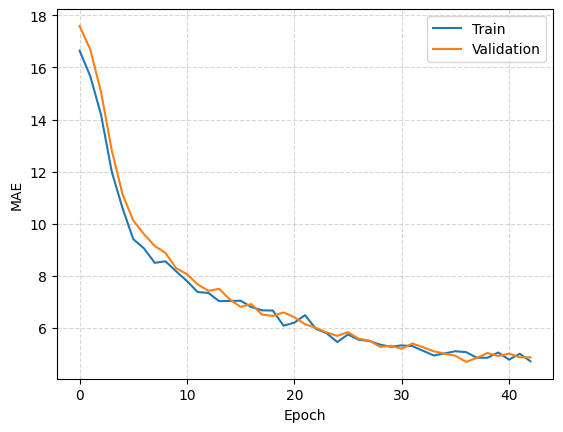

In [39]:
loss_history = mlp.history.history["loss"]
loss_history_val = mlp.history.history["val_loss"]
plt.plot(loss_history, label="Train")
plt.plot(loss_history_val, label="Validation")
plt.xlabel("Epoch")
#plt.yscale("log")
plt.ylabel("MAE")
plt.legend()
